# Road Segment Identification challenge
In this notebook , I present my work for the challenge  : https://zindi.africa/competitions/road-segment-identification

The main of the challenge , is to detecet if there is a road segment in a satellite image or not

## Importing the data

### Importing the data from my Drive


In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [ ]:
#! cp -r gdrive/MyDrive/Road\ Segment\ Identification /content/

In [ ]:
#! unzip Road\ Segment\ Identification/Images.zip  

Changing the torch version to 1.8 because the 1.9 version had some problems

In [ ]:
! pip install torch==1.8.0

     |████████████████████████████████| 735.5 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.


## Exploring the Data

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Reading csv files that contains images ids and targets

In [ ]:
train_df = pd.read_csv("Train.csv")

In [ ]:
train_df.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


### Class distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


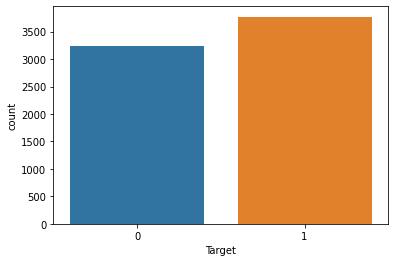

In [ ]:
sns.countplot(train_df["Target"])

### Visulaizing some sample training images

In [ ]:
from PIL import Image 
import cv2
import random

In [ ]:
def showrandom(df):
  fig, axs = plt.subplots(3,3, figsize=(15,7))
  for ax in axs.flatten():
    ind =  random.randint(0, len(df)-1)
    img_name = df["Image_ID"][ind]
    img = cv2.imread("Images/"+img_name+".tif")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{df['Target'][ind]}")
    ax.imshow(img)

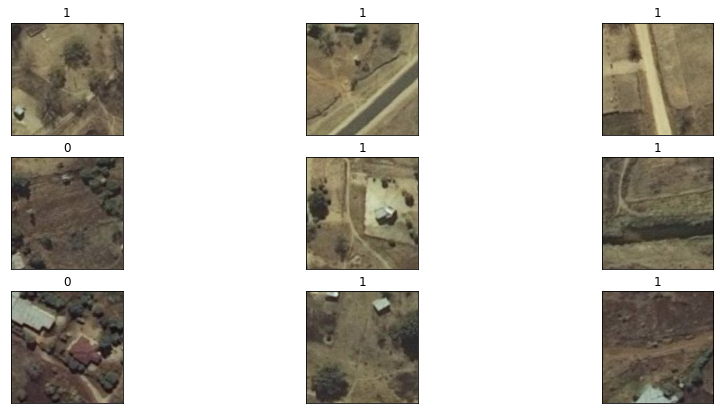

In [ ]:
showrandom(train_df)

### Visualizing the images after augmentations
#### run multiple times to see different augmentations

In [ ]:
def visualize(img):
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [ ]:
import albumentations as A
import cv2

transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])


In [ ]:
img = cv2.imread("Images/"+train_df["Image_ID"][0]+".tif")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

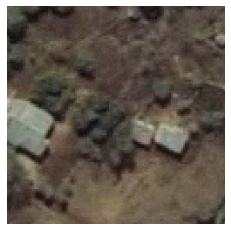

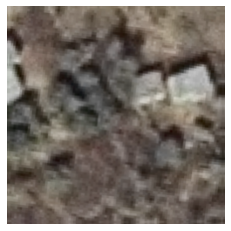

In [ ]:
visualize(img)
img = transform(image=img)['image']
visualize(img)

## Defining the dataset class

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class RoadDataset(Dataset):
  def  __init__(self, images,img_size,targets=None,preprocessing_fun=None, augmentation=None, settype = "train"):
    super(RoadDataset, self).__init__()
    self.images = images ## datafrance containtind image ids
    self.img_size = img_size ## images size
    self.settype = settype ## for training : {train - validation} or testing for submission
    self.pre = preprocessing_fun ## preprocessing functino
    self.aug = augmentation ## augmentation
    if settype == "train":
      self.targets = targets ## target values of the images
  

  def __len__(self):
    return len(self.images)

  def __getitem__(self, item):
    img_id = self.images[item]
    img = cv2.imread("Images/"+img_id+".tif") ## read the image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ## convert to RGB

    img = cv2.resize(img, (self.img_size, self.img_size), interpolation = cv2.INTER_AREA) ## resize to the target size
    

    if not self.aug is None :
      img = self.aug(image=img)["image"]  ## apply augmentation
 
    img = np.asarray(img)
    if not self.pre is None : 
      img = self.pre(img) ## apply preprocessing

    if self.settype == "train":
      return {
          "image" : torch.tensor(img, dtype=torch.float),
          "target": torch.tensor(self.targets[item], dtype=torch.float)
      }
    else : 
      return {
          "image":torch.tensor(img, dtype=torch.float)
      }



In [ ]:
def transpose_pre(x):
  ## transform the array from (W,H,C) to (C, W , H) because Convolution layers of pytorch expect it in that format
  return np.transpose(x, (2,0,1))
def normalize_pre(x):
  # devide the values by the maximum value
  return x/255.0

def pre(x):
  x = transpose_pre(x)
  x = normalize_pre(x)
  return x

In [ ]:
import albumentations as A
import cv2
aug = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])


### Training and evaluation functions

In [ ]:
from tqdm import tqdm

def train(model , dataset, dataloader, optimizer, criterion ,device="cuda"):
  model.train()
  num_batches = int(len(dataset)/dataloader.batch_size)
  tk = tqdm(dataloader, total=num_batches)

  for d in tk:
    images = d["image"]
    targets = d["target"]

    images = images.to(device, dtype=torch.float)
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()

    outputs = model(images)

    loss = criterion(outputs.view(-1), targets.view(-1))

    loss.backward()

    optimizer.step()

def evaluate(model , dataset, dataloader, device="cuda"):
  model.eval()
  num_batches = int(len(dataset)/dataloader.batch_size)
  tk = tqdm(dataloader, total=num_batches)

  final_outputs = []
  final_targets = []

  with torch.no_grad():
    for d in tk:
      images = d["image"]
      targets = d["target"]

      images = images.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(images)
      final_outputs.extend(outputs.cpu().numpy().tolist())
      final_targets.extend(targets.cpu().numpy().tolist())

  return np.array(final_outputs), np.array(final_targets)

### Model class 

In [ ]:
import torch.nn.functional as F
class CONV_BLOCK(nn.Module):
  def __init__(self, in_c, out_c, kernel_size, stride, padding):
    super(CONV_BLOCK, self).__init__()
    self.in_c = in_c
    self.out_c =out_c
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding

    self.conv = nn.Conv2d(in_c, out_c ,kernel_size=kernel_size, stride=stride, padding  =padding)
    self.bn = nn.BatchNorm2d(out_c)
    self.max_pool = nn.MaxPool2d(2)
    self.activation = nn.ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.activation(out) 
    out = self.max_pool(out)
    return out
    
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = CONV_BLOCK(3,16, 3, 1 , 0)
    self.conv2 = CONV_BLOCK(16,32 , 3,  1, 0)
    self.conv3 = CONV_BLOCK(32,64,3, 1, 0)
    self.fc_in_features = 53824
    
    self.fc1 = nn.Linear(self.fc_in_features, 512)
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(512)

    self.fc2 = nn.Linear(512, 10)
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(10)

    self.out = nn.Linear(10, 1) 

  def forward(self, x):
    bs = x.shape[0]
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)

    out = out.view(bs,-1)
    out = self.fc1(out)
    out = self.relu1(out)
    out = self.bn1(out)

    out = self.fc2(out)
    out = self.relu2(out)
    out = self.bn2(out)

    out = self.out(out)
    return torch.sigmoid(out)

### Training 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

TRAIN_BATCH_SIZE  = 32
VALID_BATCH_SIZE  = 32
EPOCHS = 20

df = pd.read_csv("Train.csv")

df = df.sample(frac=1.0).reset_index(drop=True)

train_size = int(0.8*len(df))

train_df = df.iloc[:train_size, :].reset_index(drop=True)
valid_df = df.iloc[train_size:,:].reset_index(drop=True)

train_dataset = RoadDataset(train_df["Image_ID"].values,250, train_df["Target"], pre, aug, "train")


valid_dataset = RoadDataset(valid_df["Image_ID"].values,250, valid_df["Target"], pre, None, "train")

train_loader = DataLoader(train_dataset, 
                          batch_size = TRAIN_BATCH_SIZE,
                          shuffle=True)


valid_loader = DataLoader(valid_dataset, 
                          batch_size = VALID_BATCH_SIZE)


device = ("cuda" if torch.cuda.is_available() else "cpu")

model = Net()

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience = 2, min_lr = 1e-6, mode="max")

criterion = torch.nn.BCELoss()

best_score = 0.0

earlyStoppingCounter = 0

params = model.state_dict()

for epoch in range(EPOCHS):
  print(f"EPOCH : {epoch}")
  print("Training..")
  train(model, train_dataset, train_loader, optimizer, criterion, device)
  print("Testing..")

  #train_outputs, train_targets = evaluate(model , train_dataset, train_loader, device)
  #train_labels = (train_outputs>0.5).astype(int)

  val_outputs, val_targets = evaluate(model , valid_dataset, valid_loader, device)
  val_labels = (val_outputs>0.5).astype(int)
  
  print(np.max(val_outputs), np.min(val_outputs)) # for debugging purpose

  #train_score = roc_auc_score(train_targets, train_outputs)
  val_score = roc_auc_score(val_targets, val_outputs)

  #train_acc = accuracy_score(train_targets, train_labels)
  val_acc = accuracy_score(val_targets, val_labels)

  
  if val_score>best_score :
    best_score = val_score
    params = model.state_dict()
    torch.save(params, "model.pt")
    earlyStoppingCounter = 0
  else : 
    earlyStoppingCounter += 1

  scheduler.step(val_score)

  ## You can add the train data validation as well by uncommenting the lines and replacing the zeros by the appropriate values


  print(f"Train accuracy  : {0} - Val a : {val_acc}") 
  print(f"Train ROC  : {0} - Val ROC : {val_score}")
  print("")
  if earlyStoppingCounter > 5 : 
    print("Stopped because the score is not increasing")
    break




### Generate prediction

In [ ]:
def generateSolution(model , dataset, dataloader, device="cuda"):
  model.eval()
  num_batches = int(len(dataset)/dataloader.batch_size)
  tk = tqdm(dataloader, total=num_batches)

  final_outputs = []

  with torch.no_grad():
    for d in tk:
      images = d["image"]

      images = images.to(device, dtype=torch.float)

      outputs = model(images)
      
      final_outputs.extend(outputs.cpu().numpy().tolist())

  return np.array(final_outputs)

In [ ]:
TEST_BATCH_SIZE  = 1

df = pd.read_csv("Test.csv")

test_dataset = RoadDataset(df["Image_ID"].values,250, None, pre, None, "test")


test_loader = DataLoader(test_dataset, 
                          batch_size = TEST_BATCH_SIZE,
                          shuffle=False)
model = Net()
model.to(device)
model.load_state_dict(params)

outputs = generateSolution(model,test_dataset, test_loader, device)

submission = pd.read_csv("SampleSubmission.csv")

submission["Target"]=outputs
submission.to_csv("submission.csv", index=False)
print("")
print("submission saved !")


100%|██████████| 3000/3000 [00:18<00:00, 165.89it/s]


submission saved !


## Pretrained model

In [ ]:
import torchvision
import torch.nn as nn 
import torch

### Pretrained model class
We used here the wide resnet as our pretrained model

In [ ]:
class PretrainedNet(nn.Module):
  def __init__(self):
    super(PretrainedNet, self).__init__()
    self.net = torchvision.models.wide_resnet50_2(pretrained=True)
    for param in self.net.parameters():
      param.requires_grad = False
    self.fc_in_features = self.net.fc.in_features
    self.net.fc = nn.Sequential(
        nn.Linear(self.fc_in_features, 10),
        nn.ReLU(),
        nn.Linear(10,1)
    )

  def forward(self, x):
    return torch.sigmoid(self.net(x))

In [ ]:
def transpose_pre(x):
  return np.transpose(x, (2,0,1))
def pre(x):
  x = transpose_pre(x)
  return x

import albumentations as A
import cv2
aug_train = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.Normalize() ## we added here the normalize because it is necessary to work well with the pretrained model
])

aug_eval = A.Compose([
    A.Normalize()
])


### Training the fully connected layers of the pre trained model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

TRAIN_BATCH_SIZE  = 16
VALID_BATCH_SIZE  = 16
EPOCHS = 30

df = pd.read_csv("Train.csv")

df = df.sample(frac=1.0).reset_index(drop=True)

train_size = int(0.8*len(df))

train_df = df.iloc[:train_size, :].reset_index(drop=True)
valid_df = df.iloc[train_size:,:].reset_index(drop=True)

train_dataset = RoadDataset(train_df["Image_ID"].values,224, train_df["Target"], pre, aug_train, "train")


valid_dataset = RoadDataset(valid_df["Image_ID"].values,224, valid_df["Target"], pre, aug_eval, "train")

train_loader = DataLoader(train_dataset, 
                          batch_size = TRAIN_BATCH_SIZE,
                          shuffle=True)


valid_loader = DataLoader(valid_dataset, 
                          batch_size = VALID_BATCH_SIZE)


device = ("cuda" if torch.cuda.is_available() else "cpu")

model = PretrainedNet()

model.to(device)

optimizer = torch.optim.Adam(model.net.fc.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience = 2, min_lr = 1e-6, mode="max")

criterion = torch.nn.BCELoss()

best_score = 0.0

earlyStoppingCounter = 0

params = model.state_dict()

for epoch in range(EPOCHS):
  print(f"EPOCH : {epoch}")
  print("Training..")
  train(model, train_dataset, train_loader, optimizer, criterion, device)

  print("Testing..")
  #train_outputs, train_targets = evaluate(model , train_dataset, train_loader, device)
  #train_labels = (train_outputs>0.5).astype(int)

  val_outputs, val_targets = evaluate(model , valid_dataset, valid_loader, device)
  val_labels = (val_outputs>0.5).astype(int)

  print(np.max(val_outputs), np.min(val_outputs))


  #train_score = roc_auc_score(train_targets, train_outputs)
  val_score = roc_auc_score(val_targets, val_outputs)

  #train_acc = accuracy_score(train_targets, train_labels)
  val_acc = accuracy_score(val_targets, val_labels)

  
  if val_score>best_score :
    best_score = val_score
    params = model.state_dict()
    torch.save(params, "pretrained_model.pt")
    earlyStoppingCounter = 0
  else : 
    earlyStoppingCounter += 1

  scheduler.step(val_score)
  print(f"Train accuracy  : {0} - Val accuracy : {val_acc}")
  print(f"Train ROC  : {0} - Val ROC : {val_score}")
  print("")
  if earlyStoppingCounter > 5 : 
    print("Stopped because the score is not increasing")
    break




#### Generate submission

In [ ]:
TEST_BATCH_SIZE  = 1

df = pd.read_csv("Test.csv")

test_dataset = RoadDataset(df["Image_ID"].values,224, None, pre, aug_eval, "test")


test_loader = DataLoader(test_dataset, 
                          batch_size = TEST_BATCH_SIZE,
                          shuffle=False)
model = PretrainedNet()
model.to(device)
model.load_state_dict(params)

outputs = generateSolution(model,test_dataset, test_loader, device)

submission = pd.read_csv("SampleSubmission.csv")

submission["Target"]=outputs
submission.to_csv("submission.csv", index=False)
print("")
print("submission saved !")
